In [1]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [3]:
#unzip file
!unzip "A_Z_Handwritten_Data.csv.zip"

Archive:  A_Z_Handwritten_Data.csv.zip
  inflating: A_Z Handwritten Data.csv  


In [4]:
#loads the images and labels from the A_Z dataset
def load_az_dataset(datasetPath):
	# initialize the list of data and labels
	data = []
	labels = []
	# loop over the rows of the A-Z handwritten digit dataset
	for row in open(datasetPath):
		# parse the label and image from the row
		row = row.split(",")
		label = int(row[0])
		image = np.array([int(x) for x in row[1:]], dtype="uint8")
		# images are represented as single channel (grayscale) images
		# that are 28x28=784 pixels -- we need to take this flattened
		# 784-d list of numbers and repshape them into a 28x28 matrix
		image = image.reshape((28, 28))
		# update the list of data and labels
		data.append(image)
		labels.append(label)
        # convert the data and labels to NumPy arrays
	data = np.array(data, dtype="float32")
	labels = np.array(labels, dtype="int")
	# return a 2-tuple of the A-Z data and labels
	return (data, labels)

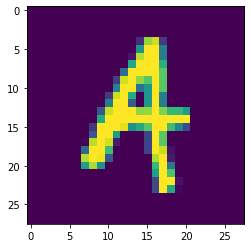

0


In [5]:
# Model / data parameters
num_classes = 26
input_shape = (28, 28, 1)

#define path to data
data_path = "A_Z Handwritten Data.csv"
#define output model name
#model_name = "handwriting.model"
#load dataset
(data, labels) = load_az_dataset(data_path)
plt.imshow(np.uint8(data[0]))
plt.show()
print(labels[0])


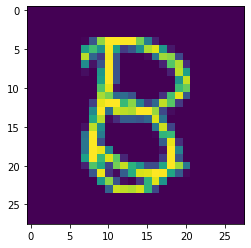

1


In [6]:
plt.imshow(np.uint8(data[20000]))
plt.show()
print(labels[20000])

In [ ]:
# add a channel dimension to every image in the dataset and scale the
# pixel intensities of the images from [0, 255] down to [0, 1]
data = np.expand_dims(data, axis=-1)
data /= 255.0

le = LabelBinarizer()
labels = le.fit_transform(labels)
counts = labels.sum(axis=0)
# account for skew in the labeled data
classTotals = labels.sum(axis=0)
classWeight = {}
# loop over all classes and calculate the class weight
for i in range(0, len(classTotals)):
	classWeight[i] = classTotals.max() / classTotals[i]
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data,
	labels, test_size=0.20, stratify=labels, random_state=42)

print("trainX shape:", trainX.shape)
print(trainX.shape[0], "train samples")
print(testX.shape[0], "test samples")


# convert class vectors to binary class matrices
#trainY = keras.utils.to_categorical(trainY, num_classes)
#testY = keras.utils.to_categorical(testY, num_classes)

trainX shape: (297960, 28, 28, 1)
297960 train samples
74491 test samples


In [ ]:
#build the model
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dropout (Dropout)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 26)                2

In [ ]:
#train the model
batch_size = 128
epochs = 15

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(trainX, trainY, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/15
4191/4191 [==============================] - 55s 6ms/step - loss: 0.3095 - accuracy: 0.9112 - val_loss: 0.1139 - val_accuracy: 0.9682
Epoch 2/15
4191/4191 [==============================] - 26s 6ms/step - loss: 0.1469 - accuracy: 0.9584 - val_loss: 0.0841 - val_accuracy: 0.9780
Epoch 3/15
4191/4191 [==============================] - 26s 6ms/step - loss: 0.1235 - accuracy: 0.9651 - val_loss: 0.0745 - val_accuracy: 0.9796
Epoch 4/15
4191/4191 [==============================] - 26s 6ms/step - loss: 0.1112 - accuracy: 0.9686 - val_loss: 0.0695 - val_accuracy: 0.9819
Epoch 5/15
4191/4191 [==============================] - 26s 6ms/step - loss: 0.1043 - accuracy: 0.9703 - val_loss: 0.0647 - val_accuracy: 0.9831
Epoch 6/15
4191/4191 [==============================] - 26s 6ms/step - loss: 0.0981 - accuracy: 0.9720 - val_loss: 0.0614 - val_accuracy: 0.9835
Epoch 7/15
4191/4191 [==============================] - 25s 6ms/step - loss: 0.0934 - accuracy: 0.9734 - val_loss: 0.0582 - val_ac

In [ ]:
#evaluate the model
score = model.evaluate(testX, testY, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.05032467842102051
Test accuracy: 0.9874078631401062


In [ ]:
# Convert the model.
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpq_y7p6kc/assets


INFO:tensorflow:Assets written to: /tmp/tmpq_y7p6kc/assets


In [ ]:
!ls -l model.tflite

-rw-r--r-- 1 root root 244432 Oct 13 01:11 model.tflite


In [ ]:
#quantize
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tf_quant = converter.convert()

# Save the model.
with open('quant_model.tflite', 'wb') as f:
  f.write(tf_quant)


INFO:tensorflow:Assets written to: /tmp/tmp6b8wzgip/assets


INFO:tensorflow:Assets written to: /tmp/tmp6b8wzgip/assets


AttributeError: ignored

In [ ]:
!ls -l quant_model.tflite

-rw-r--r-- 1 root root 65888 Oct 13 01:21 quant_model.tflite
